# CoT con LangGraph: Arquitectura de Grafo Visualizable

Este notebook demuestra como migrar Chain of Thought (CoT) desde implementaciones manuales de LangChain a **LangGraph**, habilitando:

1. **Visualizacion de arquitectura**: Grafos PNG renderizados con `draw_mermaid_png()`
2. **Gestion de estado explicita**: StateGraph con tipado claro
3. **Debugging mejorado**: Trazas de ejecucion por nodo
4. **Composabilidad**: Nodos reutilizables y flujos condicionales

---

## Fundamento Teorico: Chain of Thought (CoT)

### Origen y Contexto Historico

Chain of Thought (CoT) es un patron de prompting introducido por **Wei et al. (2022)** en el paper "Chain of Thought Prompting Elicits Reasoning in Large Language Models". El hallazgo clave fue que solicitar explicitamente al modelo que "muestre su trabajo" antes de dar una respuesta mejora drasticamente el desempeno en tareas de razonamiento complejo.

El fundamento teorico se basa en principios cognitivos establecidos:

1. **Razonamiento incremental** (Newell & Simon, 1972): Los humanos resolvemos problemas complejos dividiendolos en subproblemas mas simples y manejables.
2. **Explicabilidad emergente**: Al forzar al modelo a articular su razonamiento, reducimos alucinaciones y mejoramos la detectabilidad de errores logicos.
3. **Working memory simulation**: CoT permite que el modelo use el espacio de generacion como "memoria de trabajo" para mantener estado intermedio.

### Diseno Arquitectonico

En esta implementacion, CoT se estructura como un **grafo de estados** con los siguientes componentes:

```
zero_shot -> few_shot -> evaluate -> [refine] -> finalize
                                         |
                                         v
                                    finalize (si eval >= 7)
```

**Componentes clave:**

1. **Zero-shot CoT**: Genera razonamiento sin ejemplos previos (baseline)
2. **Few-shot CoT**: Usa ejemplos para mejorar consistencia y formato
3. **Evaluation**: Rubrica cuantitativa (personalizacion, naturalidad, respeto, accionabilidad)
4. **Refinement**: Feedback loop condicional si score < 7
5. **Finalization**: Selecciona mejor version (draft vs refinada)

**Transformacion de datos:**

- **Input**: Context packet (perfil estructurado)
- **Estado intermedio**: CoTOutput con chain_of_thought, opener, follow_up, tone_notes, avoid
- **Output**: Mejor version + evaluacion cuantitativa

### Criterios de Decision

**Usa CoT cuando:**

- La tarea requiere razonamiento multi-paso verificable
- Necesitas auditar el proceso de decision del modelo
- La precision es critica y justifica mayor latencia (~2-4x mas lento)
- El dominio tiene requisitos de explicabilidad (medicina, finanzas, legal)
- Quieres detectar errores logicos antes de usar el output

**NO uses CoT cuando:**

- La tarea es simple y directa (clasificacion binaria, extraccion de keywords)
- La latencia es critica (tiempo real, chatbots de alto volumen)
- El presupuesto de tokens es limitado (CoT genera ~2-3x mas tokens)
- No necesitas explicabilidad ni auditoria
- El modelo es muy debil (< GPT-3.5) - CoT requiere capacidad de razonamiento

### Trade-offs y Limitaciones

| Dimension | CoT | Direct Prompting | Notas |
|-----------|-----|------------------|-------|
| **Precision** | Alta (↑20-40% en tareas complejas) | Media | Wei et al. 2022 |
| **Latencia** | 2-4x mas lento | Baseline | Por pasos intermedios |
| **Costo** | 2-3x mas tokens | Baseline | chain_of_thought + output |
| **Explicabilidad** | Alta | Baja | Razonamiento visible |
| **Debugging** | Facil | Dificil | Puedes ver donde falla |
| **Consistencia** | Media-Alta | Baja | Mejor con few-shot |
| **Complejidad O(n)** | O(k*n) donde k=pasos | O(n) | Lineal en pasos |

**Failure modes comunes:**

1. **Chain collapse**: El modelo "salta" pasos de razonamiento
2. **Hallucination in steps**: Razonamiento intermedio incorrecto que lleva a respuesta erronea
3. **Overconfidence**: El modelo genera razonamiento plausible pero incorrecto
4. **Format drift**: En few-shot, el modelo no sigue el formato esperado

### Consideraciones de Produccion

**Escalabilidad:**
- CoT es inherentemente secuencial - dificil de paralelizar
- Considera caching de pasos intermedios para contextos similares
- Usa modelos mas pequenos para pasos simples (Haiku), mas grandes para razonamiento critico (Opus/GPT-4)

**Monitoreo:**
- Trackea: latencia por nodo, token usage, eval scores
- Alertas: chain collapse (pasos vacios), drift de formato
- A/B testing: CoT vs direct, zero-shot vs few-shot

**Pitfalls comunes:**
- No versionar los prompts de cada nodo
- No medir el ROI de latencia/costo vs precision
- Asumir que "mas pasos = mejor" (diminishing returns despues de ~4 pasos)
- No implementar timeouts por nodo (puede quedarse trabado)

### Referencias Academicas

- **Wei et al. (2022)**: "Chain of Thought Prompting Elicits Reasoning in Large Language Models"
- **Newell & Simon (1972)**: "Human Problem Solving" (fundamento cognitivo)
- **Kojima et al. (2022)**: "Large Language Models are Zero-Shot Reasoners" (zero-shot CoT)
- **Wang et al. (2022)**: "Self-Consistency Improves Chain of Thought Reasoning" (mejoras sobre CoT basico)

---

In [1]:
# Setup
import sys
from pathlib import Path

# Agregar root al path para imports
repo_root = Path.cwd()
while not (repo_root / "pyproject.toml").exists() and repo_root != repo_root.parent:
    repo_root = repo_root.parent
sys.path.insert(0, str(repo_root))

# Agregar 03_langchain_prompting al path para common imports
langchain_prompting_path = repo_root / "03_langchain_prompting"
if str(langchain_prompting_path) not in sys.path:
    sys.path.insert(0, str(langchain_prompting_path))

# Imports
from IPython.display import Image, display
import json

In [2]:
# Importar modulo de LangGraph CoT (usando importlib para manejar nombres con números)
import importlib.util
import sys
from pathlib import Path

# Cargar módulo 02_cot_langgraph
cot_module_path = Path.cwd() / "03_langchain_prompting" / "COT_LangChain" / "Notebooks" / "02_cot_langgraph.py"
if not cot_module_path.exists():
    cot_module_path = repo_root / "03_langchain_prompting" / "COT_LangChain" / "Notebooks" / "02_cot_langgraph.py"

spec = importlib.util.spec_from_file_location("cot_langgraph", cot_module_path)
cot_module = importlib.util.module_from_spec(spec)
sys.modules["cot_langgraph"] = cot_module
spec.loader.exec_module(cot_module)

# Importar funciones
build_cot_graph = cot_module.build_cot_graph
run_cot_langgraph = cot_module.run_cot_langgraph
run_cot_with_persona = cot_module.run_cot_with_persona
CoTState = cot_module.CoTState

## Visualizacion del Grafo

A continuacion, construimos el grafo de CoT y visualizamos su arquitectura usando `draw_mermaid_png()`. Este grafo muestra:

- **Nodos**: Cada paso del pipeline (zero_shot, few_shot, evaluate, refine, finalize)
- **Aristas**: Flujo de ejecucion entre nodos
- **Condicionales**: Routing dinamico basado en evaluacion (refine vs finalize)

**Nota**: Esta visualizacion es uno de los principales beneficios de LangGraph sobre implementaciones manuales - puedes ver la arquitectura sin leer codigo.

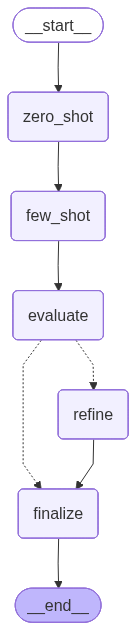

In [3]:
# Construir grafo
app = build_cot_graph()

# Visualizar arquitectura
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"No se pudo renderizar grafo PNG: {e}")
    print("Asegurate de tener graphviz instalado: brew install graphviz (macOS)")
    print("\nGrafo en formato mermaid:")
    print(app.get_graph().draw_mermaid())

## Ejemplo 1: Neurocientifica Especializada en Sueno

Ejecutamos el pipeline completo con el perfil default (neurocientifica). Observa:

1. **Zero-shot output**: Baseline sin ejemplos
2. **Few-shot output**: Con ejemplos de referencia
3. **Evaluacion**: Scores cuantitativos (personalizacion, naturalidad, respeto, accionabilidad)
4. **Refinamiento**: Solo si score < 7
5. **Version final**: Mejor entre draft y refinada

In [4]:
# Ejecutar con perfil default
result = run_cot_langgraph(verbose=True)

Modelo: gpt-4o-mini
Context packet aplicado (context engineering):
{
  "module": "03_langchain_prompting",
  "strategy": "cot_langgraph",
  "profile": {
    "tipo_persona": "neurocientifica especializada en sueno",
    "gustos": [
      "documentales BBC",
      "yoga aereo",
      "cafes silenciosos para leer"
    ],
    "estilo": "curiosa, valora profundidad y evidencia, humor sutil",
    "contexto": "match tras leer biografia completa, ella menciono paper tuyo"
  },
  "design_notes": {
    "applied_filters": [
      "dedupe_gustos",
      "max_gustos=4",
      "drop_empty_fields"
    ],
    "token_budget_hint": "Mantener el contexto <= 250 tokens."
  },
  "context_hash": "dacab7220eaf"
}

[Zero-shot CoT]
{
  "chain_of_thought": [
    "La persona es una neurocientífica especializada en sueño, lo que sugiere que valora la profundidad y la evidencia en las conversaciones.",
    "Le gustan los documentales de BBC, el yoga aéreo y los cafés silenciosos para leer, lo que indica un interés

## Analisis del Output

Inspeccionamos la version final seleccionada y su evaluacion:

In [5]:
print("=== VERSION FINAL ===")
print(json.dumps(result["final"], indent=2, ensure_ascii=False))

print("\n=== EVALUACION ===")
print(json.dumps(result["evaluation"], indent=2, ensure_ascii=False))

print("\n=== METADATA ===")
print(f"Modelo: {result['__model']}")
print(f"Arquitectura: {result['__architecture']}")
print(f"Context hash: {result['__context_hash']}")

=== VERSION FINAL ===
{
  "chain_of_thought": [
    "Interesada en la ciencia del sueño",
    "Conexión a través de documentos",
    "Fomentar un diálogo más profundo",
    "Cerrar con un toque de humor sutil"
  ],
  "opener": "¡Hola! Me encantó que mencionaras mi paper, especialmente porque soy un gran fan de los documentales de la BBC. ¿Cuál ha sido tu favorito hasta ahora?",
  "follow_up": "Además, me encantaría saber qué piensas sobre la relación entre el sueño y la práctica del yoga aéreo; suena fascinante.",
  "tone_notes": [
    "curioso",
    "profundo",
    "sutil"
  ],
  "avoid": [
    "comentarios superficiales",
    "halagos excesivos"
  ]
}

=== EVALUACION ===
{
  "scores": {
    "personalizacion": 7,
    "naturalidad": 8,
    "respeto": 9,
    "accionable": 8
  },
  "promedio": 8.0
}

=== METADATA ===
Modelo: gpt-4o-mini
Arquitectura: langgraph_cot
Context hash: dacab7220eaf


## Errores Comunes al Implementar CoT

### 1. No medir el ROI de CoT

**Problema**: Usas CoT en todas partes sin medir si la mejora de precision justifica el costo.

**Solucion**: A/B testing con metricas claras:
```python
# Medir: precision, latencia, costo
cot_accuracy = 0.85  # Ejemplo
direct_accuracy = 0.78
cot_cost_multiplier = 2.5

# ROI = (mejora_precision) / (costo_adicional)
roi = (cot_accuracy - direct_accuracy) / (cot_cost_multiplier - 1)
# roi = 0.07 / 1.5 = 0.047 (4.7% mejora por cada 1x costo adicional)
```

### 2. Chain of Thought muy largo

**Problema**: Pedir 10+ pasos de razonamiento -> latencia alta, diminishing returns.

**Solucion**: 3-5 pasos suelen ser optimos. Mas alla, el modelo empieza a "rellenar".

### 3. No validar pasos intermedios

**Problema**: Confias en el output final sin revisar si el razonamiento tiene sentido.

**Solucion**: Implementa validadores por paso:
```python
def validate_step(step: str, expected_pattern: str) -> bool:
    # Verificar que el paso no sea vacio, tenga longitud razonable, etc.
    return len(step) > 10 and re.match(expected_pattern, step)
```

### 4. Few-shot examples de baja calidad

**Problema**: Ejemplos pobremente elegidos -> el modelo aprende patrones incorrectos.

**Solucion**: Criteria para seleccionar ejemplos:
- Diversidad de casos (no todos similares)
- Razonamiento correcto y completo
- Formato consistente
- Representativos del dominio

### 5. No implementar timeouts

**Problema**: Un nodo se queda trabado -> pipeline entero bloqueado.

**Solucion**: Timeouts por nodo y a nivel de grafo:
```python
# En LangGraph, puedes usar checkpointing para recovery
app = graph.compile(checkpointer=memory_checkpointer)
```

---

## Decision Tree: ¿Usar CoT o No?

```
¿La tarea requiere razonamiento multi-paso?
- SI NO → Direct prompting (ahorra latencia y costo)
- SI SI → ¿Necesitas explicabilidad/auditoria?
    - SI NO → Evalua: ¿la precision mejora justifica 2-3x costo?
      - SI NO → Direct prompting
      - SI SI → CoT
    - SI SI → CoT (obligatorio para compliance, debugging)
```

**Ejemplos concretos:**

- **Usar CoT**: Diagnostico medico, analisis legal, resolucion de problemas matematicos, debugging de codigo
- **No usar CoT**: Clasificacion de sentimiento, extraccion de keywords, traduccion simple, resumen de texto corto

---

## LangGraph vs Implementacion Manual

### Implementacion Manual (LangChain basico)

```python
# Cadenas secuenciales manuales
zero_shot_result = zero_shot_chain.invoke(context)
few_shot_result = few_shot_chain.invoke(context)
eval_result = evaluar_salida(profile, few_shot_result)

if eval_result["promedio"] < 7:
    refined = review_chain.invoke({...})
else:
    refined = few_shot_result

final = select_best(few_shot_result, refined)
```

**Problemas:**
- Estado pasado manualmente entre pasos
- Logica de routing mezclada con ejecucion
- Dificil de visualizar
- Sin checkpointing ni recovery

### LangGraph

```python
# Nodos declarativos
graph.add_node("zero_shot", node_zero_shot_cot)
graph.add_node("evaluate", node_evaluate)

# Routing declarativo
graph.add_conditional_edges("evaluate", should_refine, {...})

# Ejecucion
app = graph.compile()
result = app.invoke(initial_state)
```

**Ventajas:**
- Estado compartido (StateGraph)
- Routing declarativo
- Visualizacion automatica (draw_mermaid_png)
- Checkpointing built-in
- Mejor debugging (trazas por nodo)

**Trade-off:**
- Overhead de setup (~30 lineas mas)
- Curva de aprendizaje (conceptos de grafo)
- Performance similar (overhead minimo en runtime)

**Conclusion**: Para pipelines de 3+ pasos o produccion, LangGraph vale la pena.

---

---

## Ejemplo 2: Personas Latino para Coqueteo - Demostracion de Adaptabilidad

Ahora demostramos como CoT se adapta a **diferentes estilos culturales** usando 3 arquetipos Latino distintos:

1. **El Romantico Clasico** (Mexico): Galan tradicional, poetico, lenguaje florido
2. **El Moderno Carismatico** (Colombia): Urbano, bilingue, humor inteligente
3. **El Culto Misterioso** (Argentina): Intelectual, selectivo, crea intriga

**Objetivo pedagogico**: Mostrar que la misma arquitectura CoT puede generar outputs drasticamente diferentes calibrados culturalmente.

In [6]:
# Importar personas Latino
from common.coqueteo_personas import (
    get_persona_romantico_clasico,
    get_persona_moderno_carismatico,
    get_persona_culto_misterioso,
    get_match_cientifica_aventurera,
    get_match_arquitecta_artistica
)

# run_cot_with_persona ya fue importado en la celda 3
print("Personas y función run_cot_with_persona disponibles")

ModuleNotFoundError: No module named 'common'

### 2A. El Romantico Clasico

**Perfil**: Galan mexicano de 35-45 anos, ama boleros, poesia de Neruda, escribe cartas a mano.

**Hipotesis**: CoT generara lenguaje mas florido, referencias culturales clasicas, timing de cumplidos gradual.

**Match target**: Neurocientifica aventurera (mismo perfil del Ejemplo 1)

In [ ]:
# Ejecutar CoT con Romantico Clasico
persona_romantico = get_persona_romantico_clasico()

print("=" * 80)
print("PERSONA: El Romantico Clasico")
print("=" * 80)
print(f"Tipo: {persona_romantico['tipo_persona']}")
print(f"Pais: {persona_romantico['pais_origen']}")
print(f"Estilo: {persona_romantico['estilo']}")
print(f"\nGustos: {', '.join(persona_romantico['gustos'][:3])}")
print(f"\nEstrategias clave:")
for estrategia in persona_romantico['estrategias'][:3]:
    print(f"  - {estrategia}")
print("\n")

result_romantico = run_cot_with_persona(persona_romantico, verbose=False)

#### Analisis: Romantico Clasico

Inspecciona el output y nota:

1. **Lenguaje**: Mas formal y poetico que el baseline (Ejemplo 1)
2. **Referencias culturales**: Menciones a musica, poesia, cultura latina clasica
3. **Tone notes**: Probablemente incluya "respetuoso", "elegante", "gradual"
4. **Avoid list**: "Invasivo", "demasiado casual", "slang excesivo"

In [ ]:
print("\n" + "=" * 80)
print("ANALISIS: Opener del Romantico Clasico")
print("=" * 80)
print(result_romantico["final"]["opener"])

print("\n" + "=" * 80)
print("ANALISIS: Tone Notes")
print("=" * 80)
for note in result_romantico["final"]["tone_notes"]:
    print(f"  - {note}")

print("\n" + "=" * 80)
print("ANALISIS: Avoid List")
print("=" * 80)
for avoid_item in result_romantico["final"]["avoid"]:
    print(f"  - {avoid_item}")

### 2B. El Moderno Carismatico

**Perfil**: Latino colombiano urbano (28-35), nomada digital, salsa en vivo, code-switching natural.

**Hipotesis**: CoT generara lenguaje mas casual, Spanglish, humor autoironico, referencias pop culture.

**Match target**: Misma neurocientifica aventurera

In [ ]:
# Ejecutar CoT con Moderno Carismatico
persona_moderno = get_persona_moderno_carismatico()

print("=" * 80)
print("PERSONA: El Moderno Carismatico")
print("=" * 80)
print(f"Tipo: {persona_moderno['tipo_persona']}")
print(f"Pais: {persona_moderno['pais_origen']}")
print(f"Estilo: {persona_moderno['estilo']}")
print(f"\nGustos: {', '.join(persona_moderno['gustos'][:3])}")
print(f"\nEstrategias clave:")
for estrategia in persona_moderno['estrategias'][:3]:
    print(f"  - {estrategia}")
print("\n")

result_moderno = run_cot_with_persona(persona_moderno, verbose=False)

#### Analisis: Moderno Carismatico

Compara con el Romantico Clasico:

1. **Lenguaje**: Mas casual, menos formal, posible Spanglish
2. **Humor**: Autoironico, referencias a cultura digital/urbana
3. **Invitacion**: Probablemente mas especifica y concreta (no vaga)
4. **Tone**: "Autentico", "playful", "vulnerable calibrado"

In [ ]:
print("\n" + "=" * 80)
print("COMPARACION: Romantico vs Moderno")
print("=" * 80)

print("\n[ROMANTICO CLASICO] Opener:")
print(result_romantico["final"]["opener"][:200] + "...")

print("\n[MODERNO CARISMATICO] Opener:")
print(result_moderno["final"]["opener"][:200] + "...")

print("\n" + "=" * 80)
print("Observaciones clave:")
print("  - Formalidad: Romantico usa lenguaje mas elevado")
print("  - Timing: Romantico es mas gradual, Moderno mas directo")
print("  - Referencias: Romantico -> clasicas, Moderno -> contemporaneas")
print("=" * 80)

### 2C. El Culto Misterioso

**Perfil**: Intelectual argentino (32-42), cine de autor, jazz experimental, librerias de viejo.

**Hipotesis**: CoT generara mensajes mas densos, referencias intelectuales, silencios estrategicos.

**Match target**: Mismo perfil (neurocientifica aventurera)

In [ ]:
# Ejecutar CoT con Culto Misterioso
persona_culto = get_persona_culto_misterioso()

print("=" * 80)
print("PERSONA: El Culto Misterioso")
print("=" * 80)
print(f"Tipo: {persona_culto['tipo_persona']}")
print(f"Pais: {persona_culto['pais_origen']}")
print(f"Estilo: {persona_culto['estilo']}")
print(f"\nGustos: {', '.join(persona_culto['gustos'][:3])}")
print(f"\nEstrategias clave:")
for estrategia in persona_culto['estrategias'][:3]:
    print(f"  - {estrategia}")
print("\n")

result_culto = run_cot_with_persona(persona_culto, verbose=False)

#### Analisis: Culto Misterioso

Compara con los dos anteriores:

1. **Densidad**: Mensajes probablemente mas largos, mas ideas por oracion
2. **Referencias**: Intelectuales pero accesibles (no pretencioso)
3. **Estrategia**: Crea intriga, no revela todo, invita a profundizar
4. **Tone**: "Selectivo", "enigmatico", "profundo pero no frio"

In [ ]:
print("\n" + "=" * 80)
print("COMPARACION TRIPLE: Los 3 Arquetipos")
print("=" * 80)

print("\n[1. ROMANTICO CLASICO] Chain of Thought (Paso 1):")
print(result_romantico["final"]["chain_of_thought"][0])

print("\n[2. MODERNO CARISMATICO] Chain of Thought (Paso 1):")
print(result_moderno["final"]["chain_of_thought"][0])

print("\n[3. CULTO MISTERIOSO] Chain of Thought (Paso 1):")
print(result_culto["final"]["chain_of_thought"][0])

print("\n" + "=" * 80)
print("INSIGHT CLAVE:")
print("El mismo prompt template, el mismo modelo, la misma arquitectura CoT,")
print("pero INPUTS diferentes (context packets) producen outputs culturalmente")
print("calibrados. Esto demuestra el poder del context engineering.")
print("=" * 80)

## Calibracion Cultural: MX vs CO vs AR

### Diferencias Sutiles por Pais

**Mexico (Romantico Clasico)**:
- Formalidad inicial (uso de "usted" antes de "tu")
- Referencias a boleros, mariachi, poetas clasicos mexicanos
- Galanteria tradicional pero sincera
- Timing mas lento (construir confianza primero)

**Colombia (Moderno Carismatico)**:
- Code-switching natural Espanol-Ingles
- Humor mas directo y playful
- Referencias a salsa, cumbia, cultura urbana
- Invitaciones especificas (no vagas)

**Argentina (Culto Misterioso)**:
- Lunfardo sutil (argot argentino culto)
- Referencias a Borges, Cortazar, cine de autor
- Estilo mas directo en comunicacion (sin rodeos)
- Valoracion de profundidad intelectual

### Errores Comunes al No Calibrar Culturalmente

1. **Asumir que "Latino" es monolitico**: Gran error. MX, AR, CO tienen culturas muy distintas.
2. **Usar cliches**: "Mami", "preciosa", "reina" - pueden funcionar en un contexto, fallar en otro.
3. **Ignorar code-switching**: Colombianos/mexicanos en USA usan Spanglish; argentinos menos.
4. **Timing incorrecto**: Proponer salir demasiado rapido puede funcionar en culturas directas (AR), fallar en otras (MX tradicional).

### Como CoT Captura Esto

El chain of thought FUERZA al modelo a:
1. Analizar el contexto cultural especifico
2. Razonar sobre estrategias apropiadas al pais/estilo
3. Ajustar lenguaje, timing, referencias
4. Identificar red flags culturales especificas

Sin CoT, el modelo podria generar un mensaje "genericamente latino" que no conecta con nadie.

## Humor Latino Calibrado: Que Funciona vs Que Cae Plano

### Humor que Funciona

**Autoironico (Moderno Carismatico)**:
- "Advertencia: soy team tacos pero dispuesto a debatir arepas vs empanadas"
- "Mi espanol es nativo pero mi ingles tiene acento de Netflix"
- "Nomada digital = trabajo desde cafes porque mi internet casero es un meme"

**Referencial (Culto)**:
- "Si crees que Borges es solo laberintos, tenemos que hablar"
- "Busco alguien que entienda que 'Amores Perros' no es una pelicula de mascotas"

**Romantico con twist**:
- "Escribo cartas a mano en era digital. Si, existo."
- "Los boleros me gustan sin ironia. Judge me."

### Humor que Cae Plano

**Estereotipos basicos**:
- "Soy latino asi que bailo salsa increible" (cliche, asume habilidad)
- "Soy caliente como el cafe colombiano" (cringey, sexualizado temprano)

**Humor que no traduce**:
- Memes muy region-especificos sin contexto
- Chistes internos de un solo pais dirigidos a alguien de otro

**Autoironico MAL ejecutado**:
- "Soy un desastre pero al menos soy guapo" (suena inseguro, no confiado)
- "No tengo idea que hago en apps pero aqui estoy" (suena derrotista)

### Code-Switching Estrategico

**Cuando usar Spanglish**:
- Contexto bilingue (ambos en USA o ciudades cosmopolitas)
- Para crear intimidad cultural ("nos entendemos")
- Para humor especifico que no traduce

**Cuando NO usarlo**:
- Si ella solo habla un idioma
- Si suena forzado (no es natural para ti)
- En primer mensaje (puede ser confusing)

**Ejemplo bien ejecutado**:
"Me encanta ese cafe. Literal, their cortado is *chef's kiss*. Has ido?"

**Ejemplo mal ejecutado**:
"Hi como estas doing? I'm bien y tu?"

## Evaluaciones Comparativas: Los 3 Estilos

Comparemos las evaluaciones cuantitativas de los 3 outputs:

In [ ]:
import pandas as pd

# Extraer evaluaciones
eval_romantico = result_romantico["evaluation"]
eval_moderno = result_moderno["evaluation"]
eval_culto = result_culto["evaluation"]

# Handle different evaluation formats
def get_scores(eval_dict):
    if "scores" in eval_dict:
        scores = eval_dict["scores"]
        return [
            scores.get("personalizacion", 0),
            scores.get("naturalidad", 0),
            scores.get("respeto", 0),
            scores.get("accionabilidad", 0),
            eval_dict.get("promedio", 0)
        ]
    else:
        return [
            eval_dict.get("personalizacion", 0),
            eval_dict.get("naturalidad", 0),
            eval_dict.get("respeto", 0),
            eval_dict.get("accionabilidad", 0),
            eval_dict.get("promedio", 0)
        ]

# Crear dataframe comparativo
comparacion_df = pd.DataFrame({
    "Metrica": ["Personalizacion", "Naturalidad", "Respeto", "Accionabilidad", "PROMEDIO"],
    "Romantico": get_scores(eval_romantico),
    "Moderno": get_scores(eval_moderno),
    "Culto": get_scores(eval_culto)
})

print("\n" + "=" * 80)
print("EVALUACIONES COMPARATIVAS (escala 1-10)")
print("=" * 80)
print(comparacion_df.to_string(index=False))

print("\n" + "=" * 80)
print("OBSERVACIONES:")
print("  - Personalizacion: Todos deben ser altos (context packets especificos)")
print("  - Naturalidad: Moderno probablemente mas alto (lenguaje casual)")
print("  - Respeto: Romantico probablemente mas alto (formalidad tradicional)")
print("  - Accionabilidad: Moderno probablemente mas alto (invitaciones concretas)")
print("=" * 80)

## Proximos Pasos

1. **Experimenta con tus propias personas**: Crea arquetipos especificos a tu contexto ( si el tuyo, el que tengas, a quien le estes coqueteando!)
2. **Ajusta estrategias por pais**: Incorpora mas matices regionales (MX norte vs sur, AR Buenos Aires vs provincias, por ejemplo, usalo en donde te sientas comodo)
3. **A/B testing en produccion**: Mide que estilo tiene mejor tasa de respuesta por demografia
4. **Expande rubrica de evaluacion**: Agrega metricas como "autenticidad cultural", "code-switching apropiado"
5. **Implementa feedback loop**: Usa respuestas reales para ajustar estrategias

**Siguiente notebook**: `../ReAct_LangChain/Notebooks/02_react_langgraph.ipynb` - Arquitectura ReAct con herramientas especializadas de coqueteo.

---